In [1]:
from SimPEG import *
import simpegEM as EM
from simpegem1d import Utils1D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 10 days


In [2]:
import matplotlib
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 100

In [3]:
mesh3D = Utils.meshutils.readUBCTensorMesh('mesh.msh')
sigma3D = Utils.meshutils.readUBCTensorModel('sigma_realistic.con', mesh3D)

In [57]:
!pwd

/Users/sgkang/Projects/AGU2014MovingDimensionsinEM/examples


In [4]:
x1 = np.arange(30)*10 - 300.
y1 = np.arange(30)*10 - 150.
xyz1 = Utils.ndgrid(x1, y1, np.r_[0.])
xc1 = -150
yc1 = 0.
r1 = np.sqrt((xyz1[:,0]-xc1)**2+(xyz1[:,1]-yc1)**2)

In [5]:
x2 = np.arange(30)*10 + 10.
y2 = np.arange(30)*10 - 150.
xyz2 = Utils.ndgrid(x2, y2, np.r_[0.])
xc2 = 150
yc2 = 0.
r2 = np.sqrt((xyz2[:,0]-xc2)**2+(xyz2[:,1]-yc2)**2)

In [6]:
dobs = np.load('bzobs_realistic.npy')
Dobs = dobs.reshape((900, 31, 2), order='F')
Dobs1 = Dobs[:,:,0]
Dobs2 = Dobs[:,:,1]

<matplotlib.contour.QuadContourSet instance at 0x10e45f290>

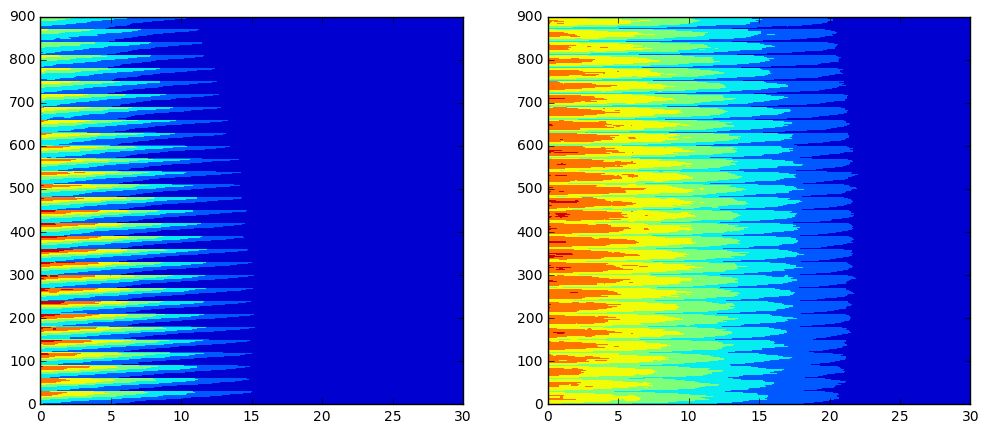

In [7]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].contourf(Dobs1)
ax[1].contourf(Dobs2)

In [8]:
meshType = 'CYL'
cs, ncx, ncz, npad = 20., 25, 30, 12
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.4), (cs,ncz), (cs,npad,1.4)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')

In [9]:
active = mesh.vectorCCz<0.
layer1 = (mesh.vectorCCz<0.) & (mesh.vectorCCz>=-60.)
layer2 = (mesh.vectorCCz<-60) & (mesh.vectorCCz>=-100.)
layer3 = (mesh.vectorCCz<-100) & (mesh.vectorCCz>=-200.)
actMap = Maps.ActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
mapping = Maps.ExpMap(mesh) * Maps.Vertical1DMap(mesh) * actMap

In [10]:
sig_half = 1e-3
sig_air = 1e-8
sig_layer1 = 1./300
sig_layer2 = 1./100
sig_layer3 = 1./10
sigma = np.ones(mesh.nCz)*sig_air
sigma[active] = sig_half
sigma[layer1] = sig_layer1
sigma[layer2] = sig_layer2
sigma[layer3] = sig_layer3
mtrue = np.log(sigma[active])

In [11]:
xc = -100
yc = 100.
dind = np.argmin(abs( xyz1[:,0]-xc)+abs( xyz1[:,1]-yc))

In [12]:
def circfun(xc, yc, r, npoint):
    theta = np.linspace(np.pi, -np.pi, npoint)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x+xc, y+yc

In [13]:
xcirc1, ycirc1 = circfun(-150., 0., 250., 60)
xcirc2, ycirc2 = circfun(150., 0., 250., 60)

In [14]:
ind = np.argwhere(xyz1[:,1]==0.)

-130.0


(-300, 300)

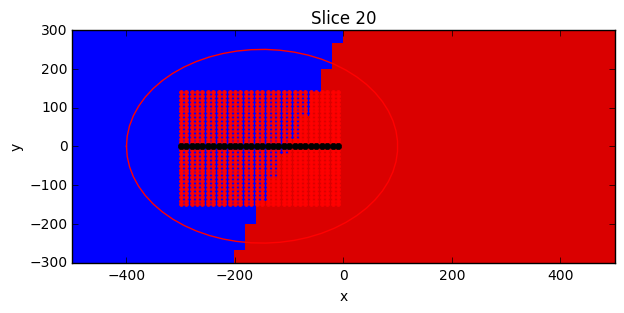

In [15]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
indz = 20
print mesh.vectorCCz[indz]
mesh3D.plotSlice(np.log10(sigma3D), ind = indz, ax = ax, clim=(-3, -0.5))
ax.plot(xyz1[:,0], xyz1[:,1], 'r.')
ax.plot(xyz1[ind,0], xyz1[ind,1], 'k.', ms=10)
# ax.plot(xyz2[:,0], xyz2[:,1], 'b.')
ax.plot(xcirc1, ycirc1, 'r-')
# ax.plot(xcirc2, ycirc2, 'b-')
ax.set_xlim(-500, 500)
ax.set_ylim(-300, 300)

In [16]:
sig_test = (sigma[active])

In [17]:
# plt.pcolor(X, Z, np.log10(Sig_test))
# plt.ylim()

(-300.0, 0.0)

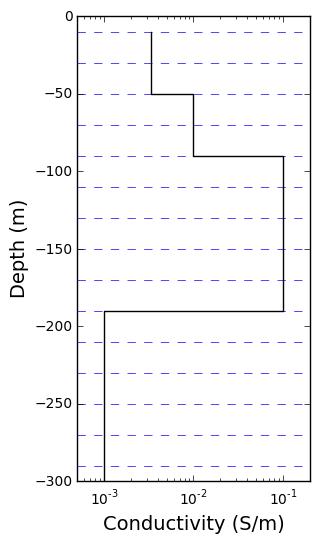

In [18]:
fig, ax = plt.subplots(1,1, figsize = (3, 6))
Utils1D.plotLayer(sig_test, mesh.vectorCCz[active], showlayers=True, ax = ax)
ax.set_ylim(-300., 0.)

In [19]:
from pymatsolver import MumpsSolver

In [20]:
prb = EM.TDEM.ProblemTDEM_b(mesh, mapping=mapping, verbose=False)

In [21]:
prb.Solver = MumpsSolver
prb.timeSteps = [(1e-4/10, 15), (1e-3/10, 15), (1e-2/10, 15), (1e-1/10, 15)]

In [26]:
# Mopt = []
# Dest=[]
# # for i in range(Dobs1[ind,:].shape[0]):
# for i in range(1):
#     rxoffset=r1[ind][i]
#     time = np.logspace(-4, -2, 31)
#     rx = EM.TDEM.RxTDEM(np.array([[rxoffset, 0., 0.]]), time, 'bz')
#     tx = EM.TDEM.SrcTDEM_CircularLoop_MVP([rx], np.array([0., 0., 0.]), radius = 250.)
#     survey = EM.TDEM.SurveyTDEM([tx])
#     if prb.ispaired:
#         prb.unpair()
#     if survey.ispaired:
#         survey.unpair()
#     prb.pair(survey)
#     std = 0.2
#     survey.dobs = Utils.mkvc(Dobs1[ind,:][i,:])
#     survey.std = survey.dobs*0 + std
#     dmisfit = DataMisfit.l2_DataMisfit(survey)
#     dmisfit.Wd = 1/(abs(survey.dobs)*std)
#     regMesh = Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
#     reg = Regularization.Tikhonov(regMesh)
#     opt = Optimization.InexactGaussNewton(maxIter = 5)
#     invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
#     # Create an inversion object
#     beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
#     betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
#     inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest])
#     m0 = np.log(np.ones(mtrue.size)*2e-3)
#     reg.alpha_s = 1e-2
#     reg.alpha_x = 1.
#     prb.counter = opt.counter = Utils.Counter()
#     opt.LSshorten = 0.5
#     opt.remember('xc')
#     mopt = inv.run(m0)
#     Mopt.append(mopt)
#     Dest.append(invProb.dpred)

In [27]:
# fig, ax = plt.subplots(1,1, figsize = (3, 6))
# Utils1D.plotLayer(np.exp(mopt), mesh.vectorCCz[active], showlayers=True, ax = ax)
# ax.set_ylim(-500., 0.)

In [27]:
# np.save('Mopt1_realistic', Mopt)
# np.save('Dest1_realistic', Dest)

In [37]:
Mopt1 = np.load('Mopt1_realistic.npy')
Dest1 = np.load('Dest1_realistic.npy')
Mopt2 = np.load('Mopt2.npy')
Dest2 = np.load('Dest2.npy')

In [38]:
Mopt1_FD = np.load('Mopt1_realistic_FD.npy')
Dest1_FD = np.load('Dest1_realistic_FD.npy')
Mopt2_FD = np.load('Mopt2_realistic_FD.npy')
Dest2_FD = np.load('Dest2_realistic_FD.npy')

In [39]:
sigma2D = np.load('./inv2D_realistic_line/invTEM2D.npy')
sigma2DFD = np.load('./inv2D_FD_realistic_line/invTEM2D.npy')

In [40]:
Sig_test = (sig_test.reshape([1,-1])).repeat(10, axis=0)
x = np.r_[xyz1[ind,0], xyz2[ind,0]]
z = mesh.vectorCCz[active]
Z, X = np.meshgrid(z, x)

In [41]:
time = np.logspace(-4, -2, 31)
z = mesh.vectorCCz[active]
Time, Xtime = np.meshgrid(time, x)

In [42]:
SigMat = np.exp(np.vstack([Mopt1, Mopt2]))
DpreMat = np.vstack([Dest1, Dest2])

In [43]:
SigMat_FD = np.exp(np.vstack([Mopt1_FD, Mopt2_FD]))
DpreMat_FD = np.vstack([Dest1_FD, Dest2_FD])

In [44]:
DobsMat = Utils.mkvc(np.vstack((Dobs1[ind, :], Dobs2[ind, :]))).reshape((60, 31), order='F')

In [45]:
DobsMatFD = np.load('./inv2D_FD_realistic_line/bzobs_FD_realistic_line.npy')

In [67]:
sigest3D = Utils.meshutils.readUBCTensorModel('sigest3D_realistic.con',mesh3D)
# sigest3D = np.load('inv3D_realistic/model_15.npy')
sigest3DFD = Utils.meshutils.readUBCTensorModel('sigest3D_realisticFD.con',mesh3D)

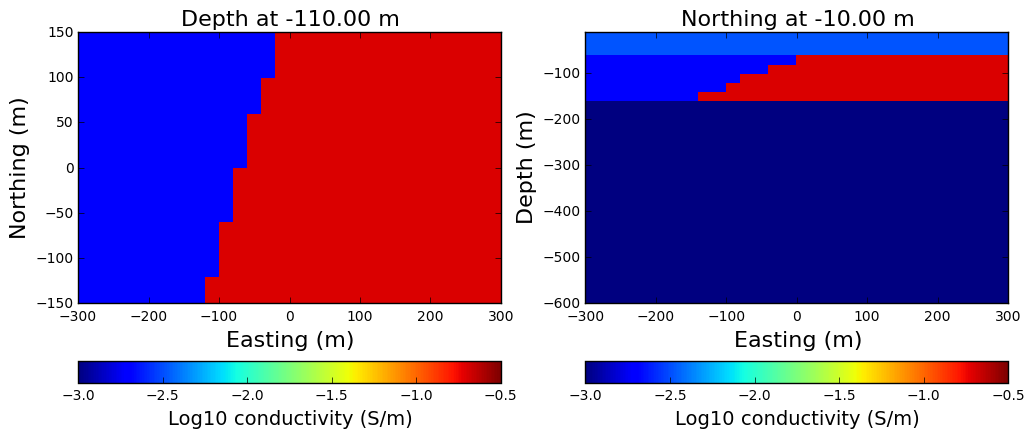

In [68]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
vmin = np.log10(Utils.mkvc(SigMat).min())
vmax = np.log10(Utils.mkvc(SigMat).max())
indy = 21
indz = 21
dat = mesh3D.plotSlice(np.log10(sigma3D), ind = indz, normal='Z', ax = ax[0], clim=(-3, -0.5))
dat = mesh3D.plotSlice(np.log10(sigma3D), ind = indy, normal='Y', ax = ax[1], clim=(-3, -0.5))
for i in range(2):
    if i==0:
        ax[i].set_xlabel('Easting (m)', fontsize = 16)
        ax[i].set_ylabel('Northing (m)', fontsize = 16)        
        ax[i].set_ylim(-150., 150.)
        ax[i].set_xlim(-300., 300.)        
        ax[i].set_title(('Depth at %5.2f m')%(mesh3D.vectorCCz[indz]), fontsize = 16)
    elif i==1:
        ax[i].set_xlabel('Easting (m)', fontsize = 16)
        ax[i].set_ylabel('Depth (m)', fontsize = 16)                
        ax[i].set_ylim(-600., -10.)
        ax[i].set_xlim(-300., 300.)        
        ax[i].set_title(('Northing at %5.2f m')%(mesh3D.vectorCCy[indy]), fontsize = 16)
    cb = plt.colorbar(dat[0], ax=ax[i], orientation = 'horizontal', ticks = [np.arange(6)*0.5-3])
    cb.set_label('Log10 conductivity (S/m)', fontsize = 14)
fig.savefig('./figures/sigtrue.png', dpi = 200)    

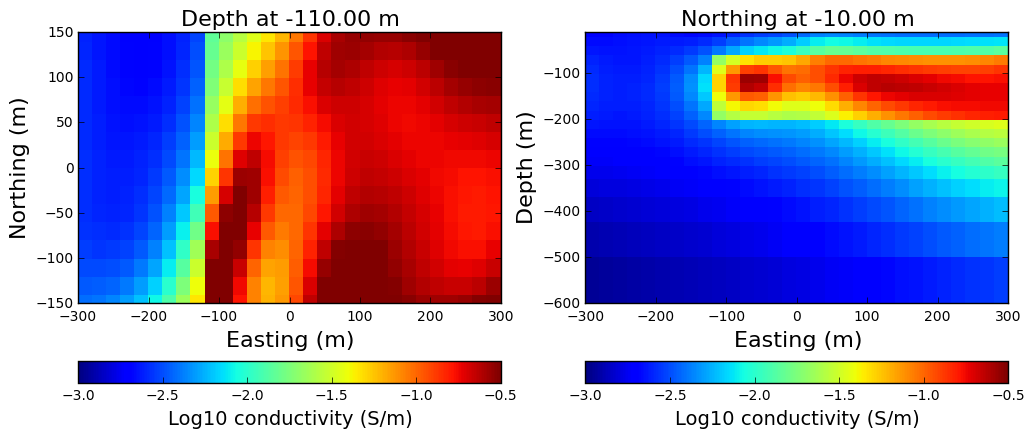

In [69]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
# vmin = np.log10(Utils.mkvc(SigMat).min())
# vmax = np.log10(Utils.mkvc(SigMat).max())
dat = mesh3D.plotSlice(np.log10(sigest3D), ind = indz, normal='Z', ax = ax[0], clim=(-3, -0.5))
dat = mesh3D.plotSlice(np.log10(sigest3D), ind = indy, normal='Y', ax = ax[1], clim=(-3, -0.5))
for i in range(2):
    if i==0:
        ax[i].set_xlabel('Easting (m)', fontsize = 16)
        ax[i].set_ylabel('Northing (m)', fontsize = 16)        
        ax[i].set_ylim(-150., 150.)
        ax[i].set_xlim(-300., 300.)        
        ax[i].set_title(('Depth at %5.2f m')%(mesh3D.vectorCCz[indz]), fontsize = 16)
    elif i==1:
        ax[i].set_xlabel('Easting (m)', fontsize = 16)
        ax[i].set_ylabel('Depth (m)', fontsize = 16)                
        ax[i].set_ylim(-600., -10.)
        ax[i].set_xlim(-300., 300.)        
        ax[i].set_title(('Northing at %5.2f m')%(mesh3D.vectorCCy[indy]), fontsize = 16)
    cb = plt.colorbar(dat[0], ax=ax[i], orientation = 'horizontal', ticks = [np.arange(6)*0.5-3])
    cb.set_label('Log10 conductivity (S/m)', fontsize = 14)
fig.savefig('./figures/sigestTD.png', dpi = 200)    

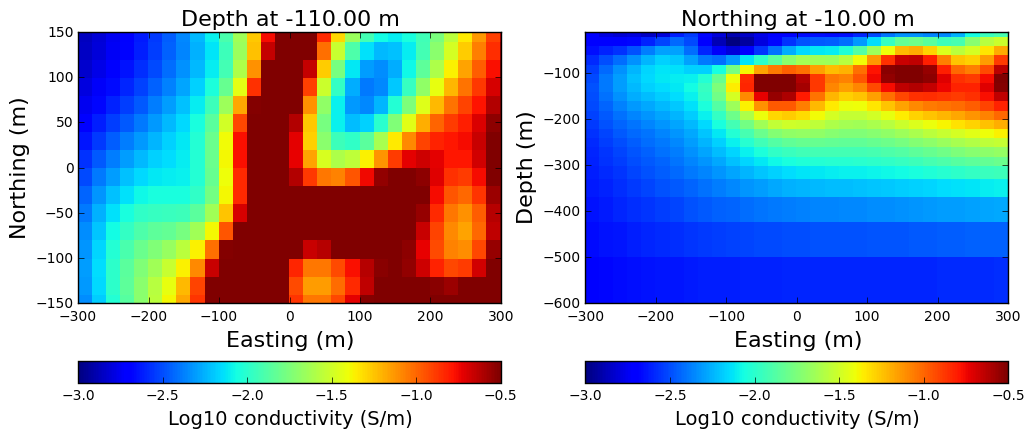

In [70]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
# vmin = np.log10(Utils.mkvc(SigMat).min())
# vmax = np.log10(Utils.mkvc(SigMat).max())
dat = mesh3D.plotSlice(np.log10(sigest3DFD), ind = indz, normal='Z', ax = ax[0], clim=(-3, -0.5))
dat = mesh3D.plotSlice(np.log10(sigest3DFD), ind = indy, normal='Y', ax = ax[1], clim=(-3, -0.5))
for i in range(2):
    if i==0:
        ax[i].set_xlabel('Easting (m)', fontsize = 16)
        ax[i].set_ylabel('Northing (m)', fontsize = 16)        
        ax[i].set_ylim(-150., 150.)
        ax[i].set_xlim(-300., 300.)        
        ax[i].set_title(('Depth at %5.2f m')%(mesh3D.vectorCCz[indz]), fontsize = 16)
    elif i==1:
        ax[i].set_xlabel('Easting (m)', fontsize = 16)
        ax[i].set_ylabel('Depth (m)', fontsize = 16)                
        ax[i].set_ylim(-600., -10.)
        ax[i].set_xlim(-300., 300.)        
        ax[i].set_title(('Northing at %5.2f m')%(mesh3D.vectorCCy[indy]), fontsize = 16)
    cb = plt.colorbar(dat[0], ax=ax[i], orientation = 'horizontal', ticks = [np.arange(6)*0.5-3])
    cb.set_label('Log10 conductivity (S/m)', fontsize = 14)
fig.savefig('./figures/sigestFD.png', dpi = 200)    

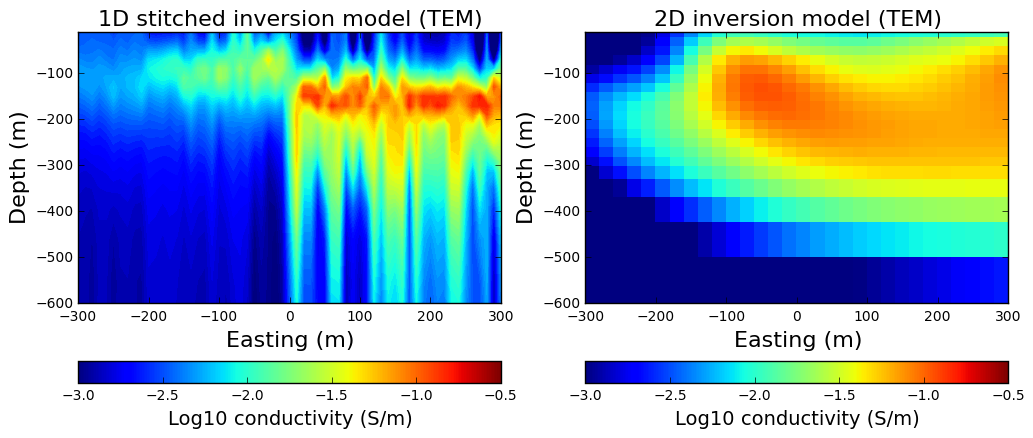

In [71]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
vmin = np.log10(Utils.mkvc(SigMat).min())
vmax = np.log10(Utils.mkvc(SigMat).max())
ax[0].contourf(X, Z, np.log10(SigMat), 100, vmin = -3, vmax = -0.5)
dat = mesh3D.plotSlice(np.log10(sigma2D), ind = 21, normal='Y', ax = ax[1], clim=(-3, -0.5))
for i in range(2):
    ax[i].set_ylim(-600., -10.)
    ax[i].set_xlim(-300., 300.)
    ax[i].set_xlabel('Easting (m)', fontsize = 16)
    ax[i].set_ylabel('Depth (m)', fontsize = 16)
    if i==0:
        ax[i].set_title('1D stitched inversion model (TEM)', fontsize = 16)
    elif i==1:
        ax[i].set_title(('2D inversion model (TEM)'), fontsize = 16)
    cb = plt.colorbar(dat[0], ax=ax[i], orientation = 'horizontal', ticks = [np.arange(6)*0.5-3])
    cb.set_label('Log10 conductivity (S/m)', fontsize = 14)
fig.savefig('./figures/1DinvTD.png', dpi = 200)    

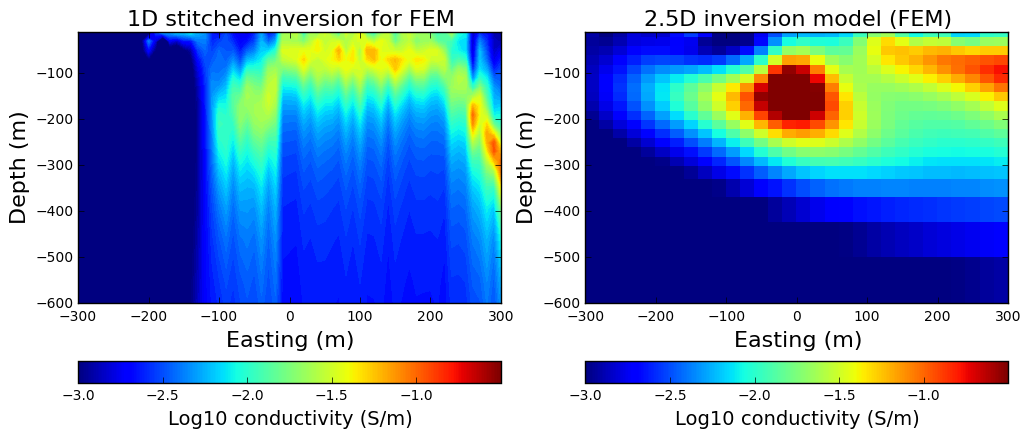

In [72]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
vmin = np.log10(Utils.mkvc(SigMat_FD).min())
vmax = np.log10(Utils.mkvc(SigMat_FD).max())
ax[0].contourf(X, Z, np.log10(SigMat_FD), 100, vmin = -3, vmax = -0.5)
dat = mesh3D.plotSlice(np.log10(sigma2DFD), ind = 21, normal='Y', ax = ax[1], clim=(-3, -0.5))
for i in range(2):
    ax[i].set_ylim(-600., -10.)
    ax[i].set_xlim(-300., 300.)
    ax[i].set_xlabel('Easting (m)', fontsize = 16)
    ax[i].set_ylabel('Depth (m)', fontsize = 16)
    if i==0:
        ax[i].set_title('1D stitched inversion for FEM', fontsize = 16)
    elif i==1:
        ax[i].set_title(('2.5D inversion model (FEM)'), fontsize = 16)
    cb = plt.colorbar(dat[0], ax=ax[i], orientation = 'horizontal', ticks = [np.arange(5)*0.5-3])
    cb.set_label('Log10 conductivity (S/m)', fontsize = 14)
fig.savefig('./figures/1DinvFD.png', dpi = 200)    

In [73]:
# fig, ax = plt.subplots(1,2, figsize = (12, 5))
# vmin = np.log10(Utils.mkvc(DpreMat).min())
# vmax = np.log10(Utils.mkvc(DpreMat).max())
# ax[1].contourf(Xtime, np.log10(Time), np.log10(DpreMat), 31, vmin = vmin, vmax = vmax)
# ax[0].contourf(Xtime, np.log10(Time), np.log10(DobsMat), 31, vmin = vmin, vmax = vmax)

In [74]:
# Itime = [0, 5, 10, 15, 20, 25, 30]
Itime = [0, 15, 30]
color = ['k', 'b', 'r', 'g', 'c', 'm', 'y']
legendobs1 = [('Obs %3.1f ms')%(time[itime]*1e3) for itime in Itime ]
legendobs2 = [('Pred1D %3.1f ms')%(time[itime]*1e3) for itime in Itime ]
legendobs3 = [('Pred2D %3.1f ms')%(time[itime]*1e3) for itime in Itime ]
legendobs = np.r_[legendobs1, legendobs2, legendobs3]

In [75]:
dpredline = np.load('./inv2D_realistic_line/dpred_13.npy')

In [76]:
dpredline = dpredline.reshape((30, 31, 2), order='F')

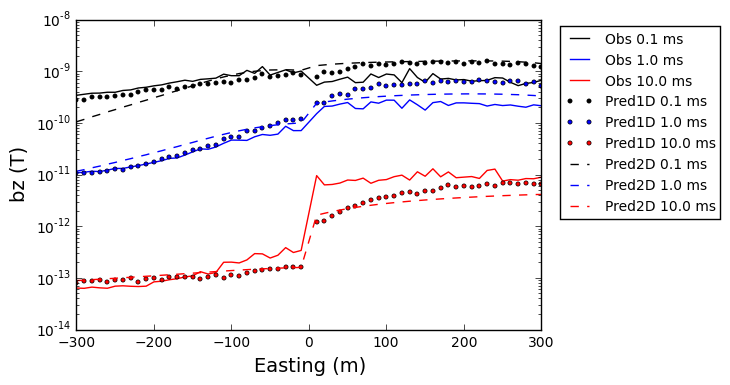

In [77]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
for icount, itime in enumerate(Itime):
    plt.semilogy(np.r_[xyz1[ind,0], xyz2[ind,0]], Utils.mkvc(DpreMat[:,itime]), color[icount])
for icount, itime in enumerate(Itime):
    plt.semilogy(np.r_[xyz1[ind,0], xyz2[ind,0]], Utils.mkvc(DobsMat[:,itime]), color[icount]+'o', ms = 3)
for icount, itime in enumerate(Itime):    
    plt.semilogy(np.r_[xyz1[ind,0], xyz2[ind,0]], Utils.mkvc(dpredline[:,itime,:]), color[icount]+'--', ms = 3)
ax.legend(legendobs,bbox_to_anchor=(1.4, 1.00), fontsize = 10)
ax.set_xlabel('Easting (m)', fontsize = 14)
ax.set_ylabel('bz (T)', fontsize = 14)
fig.savefig('./figures/1dinvobspred_TD.png', dpi = 200)

In [49]:
frequency = np.r_[1, 10., 100.]
dobs = np.load('bzobs_FD_realistic_line.npy')
dest = np.load('inv2D_FD_realistic_line/dpred_14.npy')
Dpred = abs(dobs.reshape((30, 2, frequency.size, 2), order='F'))
Dest = abs(dest.reshape((30, 2, frequency.size, 2), order='F'))

In [50]:

DpreMat_FD.shape
legendobs1 = [('Obs %3.0f Hz')%(freq) for freq in frequency ]
legendobs2 = [('Pred1D %3.0f Hz')%(freq) for freq in frequency ]
legendobs3 = [('Pred2.5D %3.0f Hz')%(freq) for freq in frequency ]
legendobs = np.r_[legendobs1, legendobs2, legendobs3]

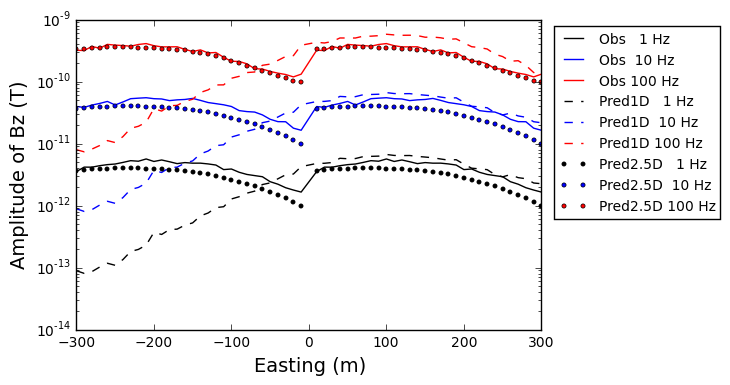

In [51]:
ind = xyz1[:,1] == 0.
absFD = lambda x, y: np.sqrt(x**2+y**2)
mradFD = lambda x, y: np.angle(x+1j*y)*1e3
realind = [0, 2, 4]
imagind = [1, 3, 5]
fig, ax = plt.subplots(1,1, figsize = (6, 4))
for itime in range(3):
    abs1 = absFD(Utils.mkvc(Dpred[:,0,itime,0]), Utils.mkvc(Dpred[:,1,itime,1]))
    abs2 = absFD(Utils.mkvc(Dpred[:,0,itime,0]), Utils.mkvc(Dpred[:,1,itime,1]))
    ax.semilogy(np.r_[xyz1[ind,0], xyz2[ind,0]], np.r_[abs1, abs2] , color[itime])
for itime in range(3):    
    abs3 = absFD(Utils.mkvc(DpreMat_FD[:,realind[itime]]), Utils.mkvc(DpreMat_FD[:,imagind[itime]]) ) 
    ax.semilogy(np.r_[xyz1[ind,0], xyz2[ind,0]], abs3, color[itime]+'--', ms = 3)    
for itime in range(3):
    abs1 = absFD(Utils.mkvc(Dest[:,0,itime,0]), Utils.mkvc(Dest[:,1,itime,1]))
    abs2 = absFD(Utils.mkvc(Dest[:,0,itime,0]), Utils.mkvc(Dest[:,1,itime,1]))        
    ax.semilogy(np.r_[xyz1[ind,0], xyz2[ind,0]], np.r_[abs1, abs2], color[itime]+'o', ms = 3)
ax.legend(legendobs,bbox_to_anchor=(1.4, 1.00), fontsize = 10)    
ax.set_xlabel('Easting (m)', fontsize = 14)
ax.set_ylabel('Amplitude of Bz (T)', fontsize = 14)    
fig.savefig('./figures/1dinvobspred_amp_FD.png', dpi = 200)

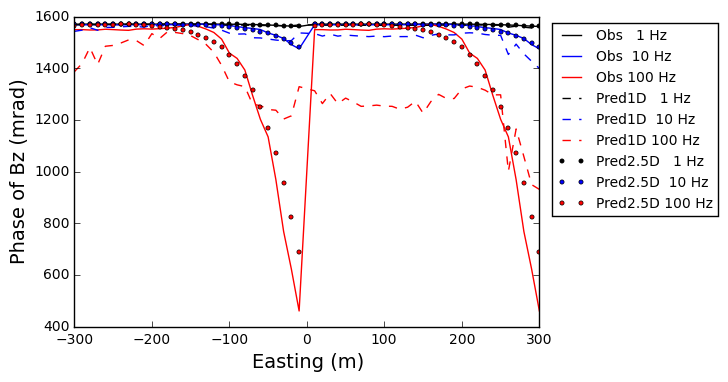

In [52]:
ind = xyz1[:,1] == 0.
absFD = lambda x, y: np.sqrt(x**2+y**2)
mradFD = lambda x, y: np.angle(x+1j*y)*1e3

fig, ax = plt.subplots(1,1, figsize = (6, 4))
for itime in range(3):
    phase1 = mradFD(Utils.mkvc(Dpred[:,0,itime,0]), Utils.mkvc(Dpred[:,1,itime,1]))
    phase2 = mradFD(Utils.mkvc(Dpred[:,0,itime,0]), Utils.mkvc(Dpred[:,1,itime,1]))
    ax.plot(np.r_[xyz1[ind,0], xyz2[ind,0]], np.r_[phase1, phase2], color[itime])
for itime in range(3):    
    phase3 = mradFD(Utils.mkvc(DpreMat_FD[:,realind[itime]]), Utils.mkvc(DpreMat_FD[:,imagind[itime]]) ) 
    ax.plot(np.r_[xyz1[ind,0], xyz2[ind,0]], phase3+np.pi*1e3, color[itime]+'--', ms = 3)       
for itime in range(3):
    phase1 = mradFD(Utils.mkvc(Dest[:,0,itime,0]), Utils.mkvc(Dest[:,1,itime,1]))
    phase2 = mradFD(Utils.mkvc(Dest[:,0,itime,0]), Utils.mkvc(Dest[:,1,itime,1]))    
    ax.plot(np.r_[xyz1[ind,0], xyz2[ind,0]], np.r_[phase1, phase2], color[itime]+'o', ms = 3)
ax.legend(legendobs,bbox_to_anchor=(1.4, 1.00), fontsize = 10)    
ax.set_xlabel('Easting (m)', fontsize = 14)
ax.set_ylabel('Phase of Bz (mrad)', fontsize = 14)    
fig.savefig('./figures/1dinvobspred_pahse_FD.png', dpi = 200)